In [1]:
!pip install spectral
!pip install tensorflow
import os
import sys
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import io
from scipy.io import loadmat
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import keras
import spectral
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
from plotly.offline import init_notebook_mode
import spectral
from tensorflow.keras import utils
init_notebook_mode(connected=True)
%matplotlib inline
#from test_utils import summary, comparator

In [2]:
dataset_folder = "Indian_pines_corrected.mat"
ground_truth_folder = "Indian_pines_gt.mat"
dataset_data = io.loadmat(dataset_folder)
ground_truth_data = io.loadmat(ground_truth_folder)
print("Keys in dataset_data:", dataset_data.keys())
print("Keys in ground_truth_data:", ground_truth_data.keys())

variable_name = 'indian_pines_corrected'
if variable_name in dataset_data:
    data = dataset_data[variable_name]
    print("Data shape:", data.shape)
    print("Data content:", data[1])
else:
    print(f"Variable '{variable_name}' not found in the .mat file.")
    
variable_name = 'indian_pines_gt'
if variable_name in ground_truth_data:
    data_gt = ground_truth_data[variable_name]
    print("Data shape:", data_gt.shape)
    print("Data content:", data_gt)
else:
    print(f"Variable '{variable_name}' not found in the .mat file.")

Keys in dataset_data: dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_corrected'])
Keys in ground_truth_data: dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_gt'])
Data shape: (145, 145, 200)
Data content: [[2576 4388 4334 ... 1047 1030 1006]
 [2747 4264 4592 ... 1055 1039 1015]
 [2750 4268 4423 ... 1047 1026 1015]
 ...
 [3859 4512 4605 ... 1056 1035 1015]
 [3686 4264 4690 ... 1051 1012 1020]
 [2744 4268 4597 ... 1047 1019 1016]]
Data shape: (145, 145)
Data content: [[3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [29]:
target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']

# Data Processing

In [3]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [4]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [5]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [6]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [7]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

In [8]:
test_ratio = 0.3
windowSize = 25
X, y = data, data_gt
X.shape, y.shape

((145, 145, 200), (145, 145))

In [9]:
K = X.shape[2]
K = 30
batch_size=32
X,pca = applyPCA(X,numComponents=K)
X.shape

(145, 145, 30)

In [10]:
X, y = createImageCubes(X, y, windowSize=windowSize)
X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [11]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((7174, 25, 25, 30), (3075, 25, 25, 30), (7174,), (3075,))

# Model

In [12]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
image_height, image_width, channel_size = X_train.shape[1],X_train.shape[2],X_train.shape[3]
# convert to one hot encoing
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

X_train = X_train / 255.0
X_test = X_test / 255.0
print(X_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 10)


In [13]:
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = tf.keras.layers.BatchNormalization()(temp)
        relu = tf.keras.layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = tf.keras.layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = tf.keras.layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = tf.keras.layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        temp = concat
    return temp

In [14]:
# transition Block
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = tf.keras.layers.BatchNormalization()(input)
    relu = tf.keras.layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = tf.keras.layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = tf.keras.layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

In [15]:
def output_layer(input):
    global compression
    BatchNorm = tf.keras.layers.BatchNormalization()(input)
    relu = tf.keras.layers.Activation('relu')(BatchNorm)
    AvgPooling = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = tf.keras.layers.Flatten()(AvgPooling)
    output = tf.keras.layers.Dense(16, activation='softmax')(flat)
    return output

# Training

In [16]:
l = 7
compression = 0.5
input = tf.keras.layers.Input(shape=(25,25,30,))
First_Conv2D = tf.keras.layers.Conv2D(30, (3,3), use_bias=False ,padding='same')(input)
First_Block = denseblock(First_Conv2D, 30, 0.5)
First_Transition = transition(First_Block, 30, 0.5)
Last_Block = denseblock(First_Transition, 30, 0.5)
output = output_layer(Last_Block)
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 25, 30)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 25, 25, 30)           8100      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 25, 25, 30)           120       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 25, 25, 30)           0         ['batch_normalization[0][0

                                                                                                  
 batch_normalization_6 (Bat  (None, 25, 25, 120)          480       ['concatenate_5[0][0]']       
 chNormalization)                                                                                 
                                                                                                  
 activation_6 (Activation)   (None, 25, 25, 120)          0         ['batch_normalization_6[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 25, 25, 15)           16200     ['activation_6[0][0]']        
                                                                                                  
 dropout_6 (Dropout)         (None, 25, 25, 15)           0         ['conv2d_7[0][0]']            
          

                                                                    ']                            
                                                                                                  
 conv2d_13 (Conv2D)          (None, 12, 12, 15)           10125     ['activation_12[0][0]']       
                                                                                                  
 dropout_12 (Dropout)        (None, 12, 12, 15)           0         ['conv2d_13[0][0]']           
                                                                                                  
 concatenate_11 (Concatenat  (None, 12, 12, 90)           0         ['concatenate_10[0][0]',      
 e)                                                                  'dropout_12[0][0]']          
                                                                                                  
 batch_normalization_13 (Ba  (None, 12, 12, 90)           360       ['concatenate_11[0][0]']      
 tchNormal

In [17]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(height_shift_range=0.1, width_shift_range= 0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
datagen.fit(Xtrain)
data = datagen.flow(x=Xtrain, y=ytrain, batch_size=32)

C:\Users\vaish\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:2092: UserWarning:

Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (7174, 25, 25, 30) (30 channels).

C:\Users\vaish\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:766: UserWarning:

NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (7174, 25, 25, 30) (30 channels).



In [19]:
from tensorflow.keras.utils import to_categorical
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Y_train_encoded = to_categorical(ytrain, num_classes=16)
Y_test_encoded = to_categorical(ytest, num_classes=16)

model.fit(Xtrain, Y_train_encoded, epochs = 100, batch_size = 32)

Epoch 1/100
225/225 [==============================] - 88s 377ms/step - loss: 0.6321 - accuracy: 0.8046
Epoch 2/100
225/225 [==============================] - 87s 387ms/step - loss: 0.0852 - accuracy: 0.9764
Epoch 3/100
225/225 [==============================] - 88s 391ms/step - loss: 0.0518 - accuracy: 0.9841
Epoch 4/100
225/225 [==============================] - 89s 394ms/step - loss: 0.0439 - accuracy: 0.9873
Epoch 5/100
225/225 [==============================] - 87s 386ms/step - loss: 0.0250 - accuracy: 0.9926
Epoch 6/100
225/225 [==============================] - 89s 395ms/step - loss: 0.0200 - accuracy: 0.9946
Epoch 7/100
225/225 [==============================] - 89s 394ms/step - loss: 0.0185 - accuracy: 0.9934
Epoch 8/100
225/225 [==============================] - 88s 393ms/step - loss: 0.0120 - accuracy: 0.9961
Epoch 9/100
225/225 [==============================] - 89s 396ms/step - loss: 0.0160 - accuracy: 0.9939
Epoch 10/100
225/225 [==============================] - 89s 396m

225/225 [==============================] - 89s 397ms/step - loss: 0.0046 - accuracy: 0.9986
Epoch 79/100
225/225 [==============================] - 89s 396ms/step - loss: 0.0039 - accuracy: 0.9993
Epoch 80/100
225/225 [==============================] - 89s 396ms/step - loss: 0.0014 - accuracy: 0.9994
Epoch 81/100
225/225 [==============================] - 89s 397ms/step - loss: 5.9468e-04 - accuracy: 0.9999
Epoch 82/100
225/225 [==============================] - 90s 399ms/step - loss: 8.4621e-05 - accuracy: 1.0000
Epoch 83/100
225/225 [==============================] - 90s 398ms/step - loss: 1.7957e-04 - accuracy: 1.0000
Epoch 84/100
225/225 [==============================] - 92s 407ms/step - loss: 0.0014 - accuracy: 0.9993
Epoch 85/100
225/225 [==============================] - 90s 402ms/step - loss: 0.0125 - accuracy: 0.9968
Epoch 86/100
225/225 [==============================] - 88s 393ms/step - loss: 0.0019 - accuracy: 0.9996
Epoch 87/100
225/225 [==============================] - 

In [20]:
model.save("best-model.hdf5")

C:\Users\vaish\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



# Validation

In [21]:
results = model.evaluate(Xtest, Y_test_encoded, batch_size=32)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

97/97 [==============================] - 6s 57ms/step - loss: 0.0264 - accuracy: 0.9909
Test loss: 0.026417136192321777
Test accuracy: 0.9908943176269531


In [22]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K)
print(Xtest.shape)
ytest = utils.to_categorical(ytest)
print(ytest.shape)

(3075, 25, 25, 30)
(3075, 16)


In [23]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

97/97 [==============================] - 6s 57ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.94      1.00      0.97       428
           2       1.00      1.00      1.00       249
           3       1.00      1.00      1.00        71
           4       0.99      1.00      1.00       145
           5       1.00      1.00      1.00       219
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00       143
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00       292
          10       1.00      0.96      0.98       737
          11       0.99      1.00      1.00       178
          12       1.00      1.00      1.00        61
          13       1.00      1.00      1.00       380
          14       1.00      0.99      1.00       116
          15       1.00      1.00      1.00        28

    accuracy              

In [24]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [25]:
def reports (Xtest,ytest):
    classification = classification_report(np.argmax(ytest, axis=1), y_pred_test, target_names=target_names)
    oa = accuracy_score(np.argmax(ytest, axis=1), y_pred_test)
    confusion = confusion_matrix(np.argmax(ytest, axis=1), y_pred_test)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(ytest, axis=1), y_pred_test)
    score = model.evaluate(Xtest, ytest, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [26]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

print(Test_loss, Test_accuracy, oa, each_acc, aa, kappa)
with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

97/97 [==============================] - 6s 60ms/step - loss: 0.0264 - accuracy: 0.9909
2.6417136192321777 99.08943176269531 99.08943089430893 [100.         100.          99.59839357 100.         100.
 100.         100.         100.         100.         100.
  96.47218453 100.         100.         100.          99.13793103
 100.        ] 99.70053182129162 98.96280880530752


97/97 [==============================] - 7s 72ms/step


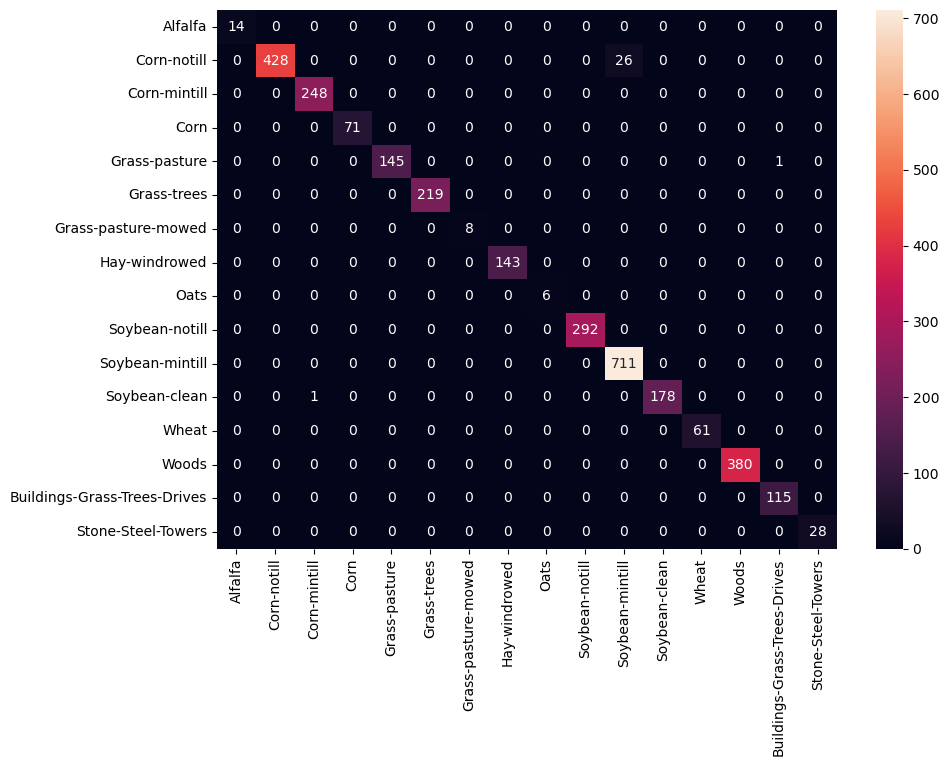

In [30]:
import seaborn as sns
plt.figure(figsize = (10,7))
pred = np.argmax(model.predict(Xtest), axis=1)
classes = target_names

mat = confusion_matrix(np.add(pred, 1), np.add(np.argmax(ytest, 1), 1))
df_cm = pd.DataFrame(mat, index = classes, columns = classes)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()